#**ECS7020P Mini project Basic** 

### **1) Author**

**Student Name : Mundrathi Lasya** 

**Student ID   :  EC22117**

### **2) Problem Formulation**

Using the MLEnd London Sounds dataset, building a machine learning pipeline that takes as an input an audio segment and predicting whether the audio segment has been recorded indoors or outdoors. The problem here is to classify the 7 seconds audio by intrepreting its acoustic environment Indoor or Outdoor. 

We will be using Supervised Machine Learning Models by using features from the librosa python package to retrive information. 

***What's Intresting about it***

Audio files are complex data types. Specifically they are discrete signals or time series, consisting of values on a temporal window/dimension.This project gives an insight to work with different audio features to classify its environment.

Additionally this project gives an inference of machine learning model that best suits this application. Furthermore, We will explore different methods to choose best hyperparameteters and compares the effectiveness of supervised models for this application.



### **3) Machine Learning Pipeline** 

The below describes the Machine Learning Pipeline

**Input**

The Input for the ML pipeline consists of a **csv file** and collection of  7 seconds **audio clips**(.wav files) recorded in different filiming locations of London. 

The csv file consists of name of the audio files along with the Area Spot, environment, Participant Number recorded in different filiming locations of London. 


**Feature Extraction**

In this stage we are loading a collection of audio files along with the dataframe where name of the audio file is given as index.  Here we are extracting spectral features using librosa library using different functions. It returns and array*(X)* of these features and a binary boolean label **y** which is *True* for *Indoor* and *False* for *Outdoor*. 

**Feature Analysis**

In this stage data having high skewness is transformed into low skewness using logorithmic, square, cube root math functions. We are reducing the skewness so that the data has smoothned curve.If the skewness of the data lies between -1 to 1 it is normally distributed. Data is inconsistent so the data is standardised by using sklearn library where the transformed data has mean as zero and varience as 1.

**Training and Tuning the model**

The processed data is given as input to the models after spliting into 70% Training and 30% Testing data. Followed by the Supervised Machine Learning Models to predict labels as Indoor and Outdoors. Each model is accesed for evaluation using accuracy metric, precision, recall, f1-score. Using RandomizedSearchCV best hyperparameters are selected that best suits the model. 

**Model Evaluation**

In this stage we will further select the best model using accuracy obtained for each model on the validation dataset(30%). The final model is selected based on accuracy, confusion matrix, classification report so that the suitable model is not biased towards any predictors. For each model we are predicting output based on the indoor or outdoor environment.
 

### **4 Transformation stage**

**Input**

Transformation Stage is the major part in this project. raw.wav data and the dataframe were given as input. Initially file name and the respective environment indoor or outdoor are stored in variables.

**Transformation**

We are decomposing the audio files into timeseries with a sampling rate of 22050. Now we further need to reduce the dimensions by extracting below mentioned spectral features.

*Note:If we are using raw audio signals as input we need to deal with thousands of dimensionals. This results into Curse of Dimensioanlity problem.* 

In this approach we are dealing with the extracted various features from these audio clips. Any audio file consists of various spectral features extracting these feature can be useful for data learning.

**Spectral Bandwidth(spec_bw)**  It is calculated by evaluating the difference between upper and lower frequencies in a continuous band of frequencies.

***Zero crossings rate :***It is the measure of number of times the amplitude of the audio signals passes through zero in the given time interval. This feature is extensively used in music genre identification, speech recognition and environment sound recognition. It is the best way to distinguish voiced and unvoiced sounds. A higher Zero crossings indicates that there is a high frequency noisy signals.

***Tempo :*** Tempo is defined as the speed of a music beat.
(https://musicinformationretrieval.com/tempo_estimation.html

***Mel Frequency Cepstral Coefficients feature(MFCC)*** 
Mel Frequency Cepstral Coefficients feature defines characteristics that describe the overall form of a curve of the amplitude spectrum and simulates the specification of human voice. This feature is widely used in modern apps performing the detection of voice activity (VAD). https://www.youtube.com/watch?v=WJI-17MNpdE

***Output***

An array of all the extracted features and their associated predictor labels were returned



In [2]:
#Importing all the necessary libraries
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa
import pandas as pd
import seaborn as sns
from sklearn import svm
from sklearn.metrics import accuracy_score,matthews_corrcoef,classification_report,ConfusionMatrixDisplay,confusion_matrix
from sklearn import metrics
import seaborn as sns
import xgboost as xb
from scipy.stats import skew
import warnings
warnings.filterwarnings('ignore')

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,# sr -sampling range
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [ ]:
def getXy(files,labels_file, scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  #fetching the file name and extracting features through signal processing from librosa library
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    file_name = file.split('/')[-1]
    yi = labels_file.loc[fileID]['in_out']=='indoor'

    #Reading the audio file where x is the wave format and sr is the sampling rate
    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)

    #Extracting various spectral and audio features  
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)
    mfcc = librosa.feature.mfcc(x,n_mfcc=40, sr=fs)
    zero_crossings = librosa.zero_crossings(x, pad=False)
    onset_env = librosa.onset.onset_strength(x, sr=fs)
    spec_bw = librosa.feature.spectral_bandwidth(x, sr=fs)
    tempo = librosa.beat.tempo(x, sr=fs)
    #extracted features are appended into a list and the dependent values into y
    xi = [power,pitch_mean,pitch_std,voiced_fr,np.mean(mfcc),np.mean(zero_crossings),np.mean(onset_env),np.mean(spec_bw),tempo[0]]
    X.append(xi)
    y.append(yi)

  return np.array(X),np.array(y)

### **5 Modelling**

Supervised Models were implemented in this notebook which is widely used for classification and regression tasks.

1.  **SVM**-I choosed this method since it uses an ***N***-dimensional hyperplane that separates ***N***-distinct features into two different classes. This method is extremely useful for higher dimensions.  
2.   **Random Forest**-It builds decision trees on a collection of samples and predicts by considering the majority vote for classfication.I choosed this method as it avoids overfitting as this model collects samples randomly and considers majority ranking for classification or average for regression.
1.  **Xgboost**-Xgboost method uses gradient boosting method. This method is known for its flexibility and portability as it uses sequential set of models to strongly understand the application. I choosed this method as it solves machine learning problems more accuratly and faster than many other models. https://www.analyticsvidhya.com/blog/2018/09/an-end-to-end-guide-to-understand-the-math-behind-xgboost/


### **6 Methodology**

***Data Exploration and analysis***

To begin with all the extracted features were placed in a Dataframe. Data having highskewness is transformed and standardised using standard scaler from sklearn library.The standardised data is analysed using pearson correlation coefficient. A heatmap is placed in this notebook which shows the relationship between all the attributes.

***Spliting and Training the model***

Data is divided into 70% training data and 30% test data here randomness while spliting the data is controlled by a random number generator and stratify parameter splits the data in equal proportions based on the labels as the data is balanced.

***Model performance*** 

Initially training data is fit to each model and their accuracy is calculated based their performance their associated hyperparamters are optimized.
Performance of the features for each model is plotted in this notebook.

**Model evaluation**

Evalution of the model is accesed through 5 evaluation metrics accuracy, Precision, recall, confusion matrix.

**OUTPUT**

The output of the pipeline will be a predicted labels as indoor or outdoor.

### **7 Dataset**
In this notebook data consists of a csv file and 2498 audio audio clips( .wav files) recorded in different filiming locations of London. A csv file consists of 5 attributes namely audio file name, area, spot, participitant id and the acoustic environment indoor or outdoor.
 

In the below glob function from python retrives the files paths that has "wav" path in it.

In [ ]:
# Accessing all the audio files from the google drive using glob
sample_path = '/content/drive/MyDrive/Data/MLEndLS_1/sample_1/*.wav'
files = glob.glob(sample_path)
print("There are totally {} audio clips".format(len(files)))

There are totally 2498 audio clips


In [ ]:
#loading a csv file consists of name of the audio files along with the Area Spot, environment, Participant Number recorded in different filiming locations of London
MLENDLS_df = pd.read_csv('/content/MLEndLS _basic.csv').set_index('file_id') 

**7.1 Data  Exploration**

The graph below shows the spectogram of different sample of indoor and outdoor.

From the below graph it is clear that the amplitude of Outdoor and Indoor differ over the 7-seconds time span so this can be considered as a feature.

0206.wav


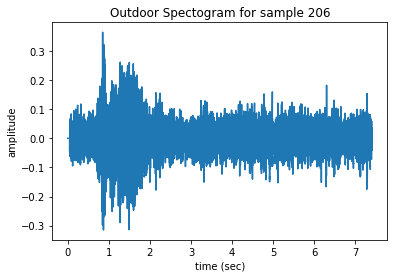

area            campus
spot            square
in_out         outdoor
Participant       S111
Name: 0206.wav, dtype: object

In [ ]:
#Visualizing the audio signal in the wave format of an outdoor sample
n=2204 #0-998
fs = None # Sampling frequency
x, fs = librosa.load(files[n],sr=fs)
fileID = files[n].split('/')[-1]
print(fileID)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.title("Outdoor Spectogram for sample 206")
plt.show()
display(ipd.Audio(files[n]))
#Information about 'n' audio signal
MLENDLS_df.loc[files[n].split('/')[-1]]

1505.wav


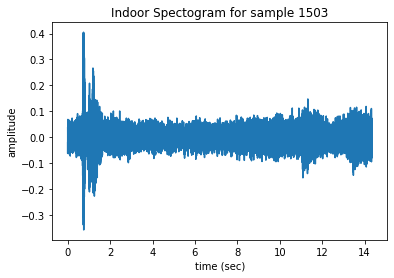

area           westend
spot           charing
in_out          indoor
Participant        S13
Name: 1505.wav, dtype: object

In [ ]:
#Visualizing the audio signal in the wave format of an indoor sample
n=5 
fs = None # Sampling frequency
x, fs = librosa.load(files[n],sr=fs)
fileID = files[n].split('/')[-1]
print(fileID)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.title("Indoor Spectogram for sample 1505")
plt.show()
display(ipd.Audio(files[n]))
#Information about 'n' audio signal
MLENDLS_df.loc[files[n].split('/')[-1]]

In [ ]:
#Placing all the extracted independent variables into X and dependent variable into y using getXy function
X,y = getXy(files, labels_file=MLENDLS_df, scale_audio=True, onlySingleDigit=True)

100%|██████████| 2498/2498 [1:02:49<00:00,  1.51s/it]


In [ ]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
print('The labels vector is', y)

The shape of X is (2498, 9)
The shape of y is (2498,)
The labels vector is [False False False ... False  True False]


In [ ]:
#Creating a dataframe with the extracted features
df = pd.DataFrame({'power': list(X[:,0]), 'pitch_mean': list(X[:, 1]), 'pitch_std':list(X[:, 2]),'voiced_fr':list(X[:, 3]), 'mfcc':list(X[:, 4]),
              'zero_crossings':list(X[:, 5]),'onset_env':X[:,6],'spec_bw':X[:,7],'tempo':list(X[:, 8]), 'in_out':list(y)})
# #Placing al the features in a CSV file for futher processing
# df.to_csv("X_y_basic_data.csv", index=False)

In [5]:
df.isna().any()
#Converting labels into numerical features for data processing
df['in_out']=df['in_out'].astype('int')

**7.2 Cleaning, Tranforming and Data Analysis**


Raw data extracted from the features has high skweness. For effective functioning of our dataset we need to reduce the skewness. Here high positive skewed values are converted using log/cbrt where as negatively skewed values are converted using square math functions.  

Plotting a graph representing the histogram and skewness of each attribute of data before tranformation and after tranformation

power - 1.9321216399232035


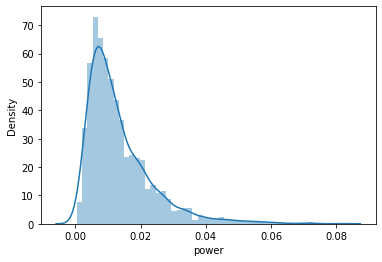

pitch_mean - 0.20709820713529473


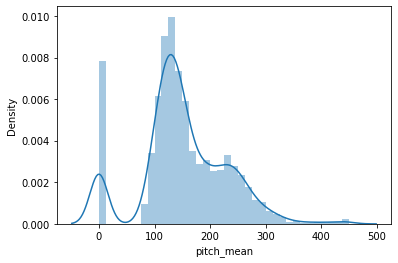

pitch_std - 2.0214120495176635


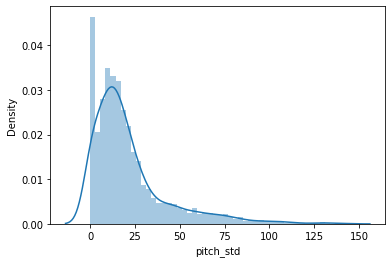

voiced_fr - 3.7427294967107256


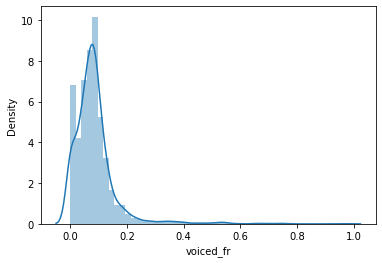

mfcc - -0.8002400572420175


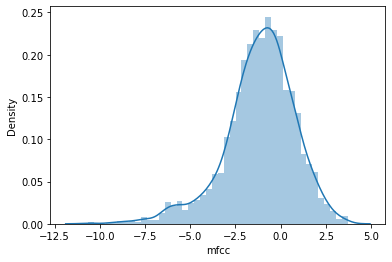

zero_crossings - 3.509379288117832


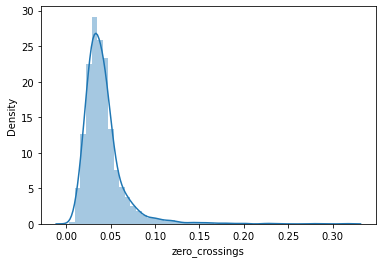

onset_env - 1.169834992363067


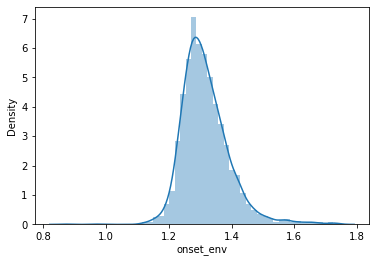

spec_bw - 0.9287146944886631


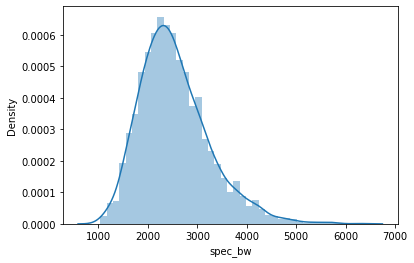

tempo - 0.10183838232917544


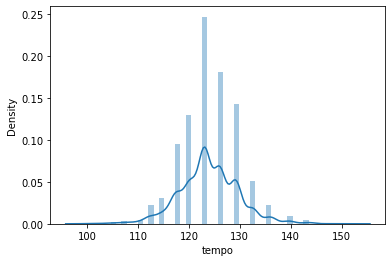

in_out - 0.10904884550469122


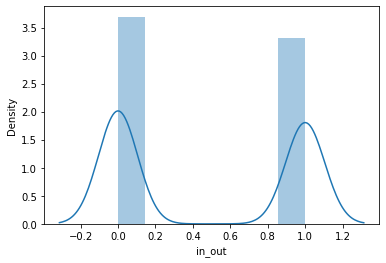

In [4]:
for col in df:
  if(col!='Gender'):
    print(col,"-",skew(df[col]))
    sns.distplot(df[col]);
  plt.show()

**Data Transformation** In this stage we are transforming the data based on their distribution.  

*   We can observe that pitch_mean of the data at 0 differs from its own distribution so data having pitch_mean zero must be an outlier.
*  Pitch std attribute has zero values in it as we cannot cuberoot or square root zero values we are replacing zero with 0.01.

*  Pitch_std, power,voiced_fr,zero_crossing has positively skewed distribution so we are reducing the skewness by using logorithmic, square root, cube root math functions. 
* *why data should be Transformed*: As the normal distribution has skewness ranging between -1 to 1 we are trying to convert the data into normally distributed through normal or guassian distribution we can derive the nature of the data.

In [6]:
data=df[df['pitch_mean']!=0.0]
#Replacing zero values with 0.01
data[data['pitch_std']==0]=0.01
#Tranforming data having high skewness
data['pitch_std']=np.cbrt(data['pitch_std'])
# data['power']=np.log(data['power'])
data['onset_env']=np.square(data['onset_env'])
data['voiced_fr']=np.log(data['voiced_fr'])
data['zero_crossings']=np.log(data['zero_crossings'])
data['tempo']=np.square(data['tempo'])
display(data.describe())

power   pitch_mean    pitch_std    voiced_fr         mfcc  \
count  2254.000000  2254.000000  2254.000000  2254.000000  2254.000000   
mean      0.012427   168.795150     2.657970    -2.584719    -1.310440   
std       0.009216    62.428941     0.772648     0.673044     1.942611   
min       0.000433     0.010000     0.000024    -5.464891   -10.662400   
25%       0.006288   122.671825     2.158017    -2.907528    -2.277735   
50%       0.009944   148.448701     2.563016    -2.519998    -1.111890   
75%       0.015638   209.480859     3.045974    -2.239913    -0.058759   
max       0.081043   449.941853     5.220849    -0.026668     3.718372   

       zero_crossings    onset_env      spec_bw         tempo       in_out  
count     2254.000000  2254.000000  2254.000000   2254.000000  2254.000000  
mean        -3.286934     1.738761  2545.904347  15385.031104     0.467622  
std          0.454144     0.217502   719.990766   1516.620598     0.499052  
min         -5.668542     0.000100     0.010000      0.000100     0.000000  
25%         -3.558540     1.607029  2047.919240  14444.511088     0.000000  
50%         -3.291592     1.702861  2443.377299  15140.533447     0.000000  
75%         -3.044700     1.834110  2936.932748  15888.102916     1.000000  
max         -1.149993     3.035331  6298.948947  23103.720589     1.000000

power - 2.1620605651427423


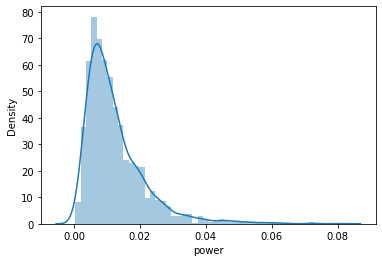

pitch_mean - 1.1628797865129124


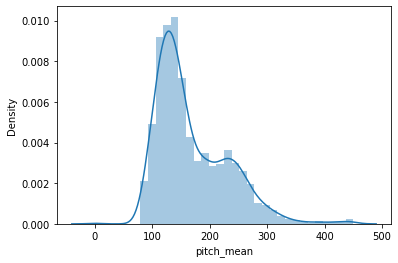

pitch_std - 0.48848823461390767


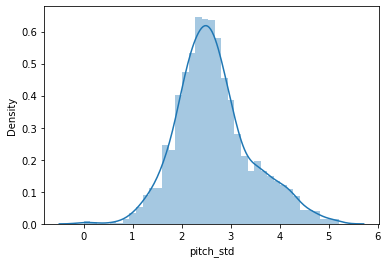

voiced_fr - -0.38585703799090487


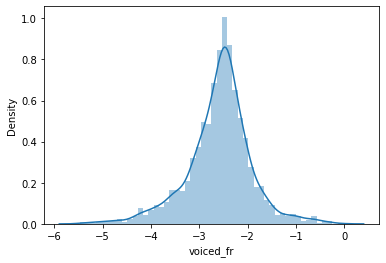

mfcc - -0.8449518749328119


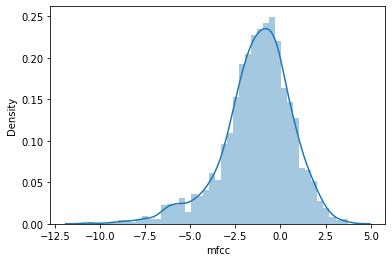

zero_crossings - 0.26817928541139197


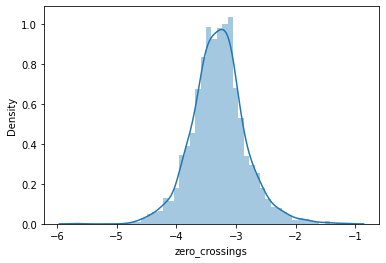

onset_env - 1.0544290126390206


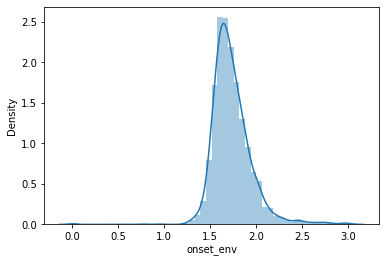

spec_bw - 0.8997284914023577


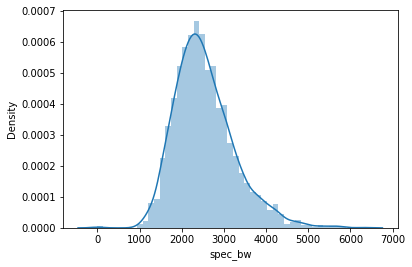

tempo - -0.6062600145139722


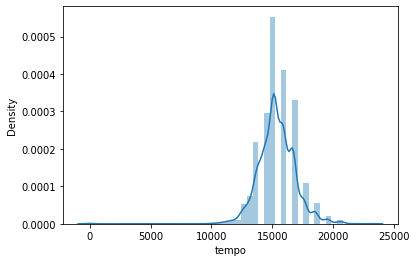

In [7]:
for col in data:
  if(col!='in_out'):
    print(col,"-",skew(data[col]))
    sns.distplot(data[col]);  
  plt.show()    

**7.2.1 Standardizing the data**

Standardising the tranformed data using standard scaler function sklearn library. All the independent variables are drawn into x and the independent varible in_out are drawn into labels

In [8]:
from sklearn.preprocessing import StandardScaler
std=StandardScaler()
#Converting boolean data type to integer datatype
data['in_out']=data['in_out'].astype(int)
data_1=data.copy()
labels=data['in_out']
data.drop(data[['in_out']],axis=1,inplace=True)
#Standardizing the tranformed data
Data = pd.DataFrame(std.fit_transform(data), columns=data.columns, index=data.index)

**7.2.2 Data Analysis**

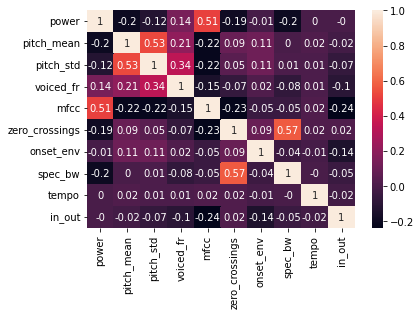

In [9]:
cor_matrix=df.corr().round(2)
sns.heatmap(cor_matrix, annot=True)
plt.show()

**correlation between features of indoor data**

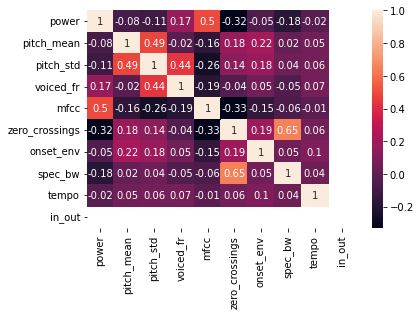

In [10]:
cor_matrix=data_1[data_1['in_out']==0].corr().round(2)
sns.heatmap(cor_matrix, annot=True)
plt.show()

**coorelation between features of outdoor data**

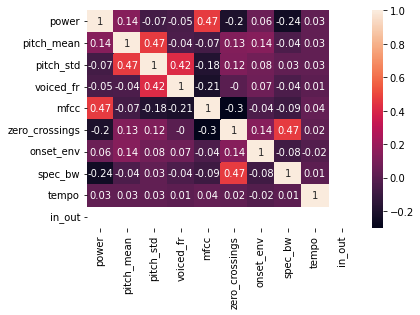

In [11]:
cor_matrix=data_1[data_1['in_out']==1].corr().round(2)
sns.heatmap(cor_matrix, annot=True)
plt.show()

**Inference:** Correlation is the value lying between -1 and +1 . it shows the relation between direction and strength of the features.
The closer the value is to 1 (or -1), the stronger a relationship.
The closer a number is to 0, the weaker the relationship.We can observe that features donot have much correlation between dependendent variable and independent variables

### **8.Results**

In [12]:
#Splitiing the dataframe into training and testing 
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(Data,labels,test_size=0.3,random_state=23,stratify=labels)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1577, 9), (677, 9), (1577,), (677,))

In [13]:
unique, counts = np.unique(y_train, return_counts=True)
print("The total number of indoor and outdoor data in training dataset are")
dict(zip(unique, counts))

The total number of indoor and outdoor data in training dataset are


{0: 840, 1: 737}

In [14]:
unique, counts = np.unique(y_val, return_counts=True)
print("The total number of indoor and outdoor data in validataion dataset are")
dict(zip(unique, counts))

The total number of indoor and outdoor data in validataion dataset are


{0: 360, 1: 317}

Note: '0' represents indoor environment and '1' represents Outdoor environment.

**8.1 Model Traning and Evaluation using Svm Model**

Training Accuracy 0.7907419150285352
Validation  Accuracy 0.7385524372230429
The support vectors are (1084, 9)
              precision    recall  f1-score   support

           0       0.83      0.72      0.77       415
           1       0.63      0.77      0.69       262

    accuracy                           0.74       677
   macro avg       0.73      0.74      0.73       677
weighted avg       0.75      0.74      0.74       677



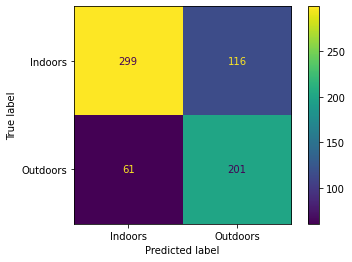

In [15]:
model  = svm.SVC()
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)
print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))
print('The support vectors are', model.support_vectors_.shape)
svm_train_accuracy=accuracy_score(y_val, yv_p)

#Confusion Matrix
cm = metrics.confusion_matrix(yv_p, (y_val))
cmd_obj=ConfusionMatrixDisplay(cm,display_labels=['Indoors','Outdoors'])
cmd_obj.plot();

#Classification Report
print(classification_report(yv_p,y_val)) 

**Inference**:

*   SVM is not an suitable model for this problem statement.

*   From the Confusion matrix we can infer that this model is incorrectly identifying the outdoor data and being more favourable indoor data which leads to underfitting the model.
*   From the classification report we can infer that this model has 0 precision,recall and fscore for outdoor data so this model is completely biased towards indoor data.



**8.2 Model Traning and Evaluation using XG Boost Model**

Training Accuracy 0.84
Validation  Accuracy 0.72
              precision    recall  f1-score   support

           0       0.76      0.72      0.74       380
           1       0.67      0.71      0.69       297

    accuracy                           0.72       677
   macro avg       0.71      0.72      0.71       677
weighted avg       0.72      0.72      0.72       677



<BarContainer object of 9 artists>

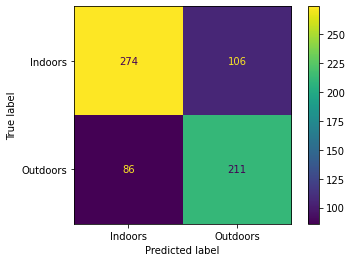

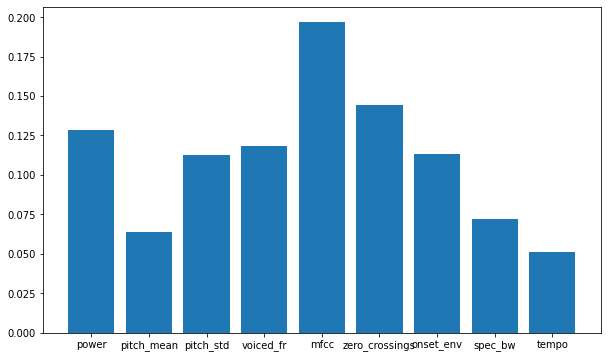

In [16]:
classifier=xb.XGBClassifier()
classifier.fit(X_train,y_train)

yt_p = classifier.predict(X_train)
yv_p = classifier.predict(X_val)

print('Training Accuracy', np.round(np.mean(yt_p==y_train),2))
print('Validation  Accuracy', np.round(np.mean(yv_p==y_val),2))
xgboost_val_accuracy=accuracy_score(y_val, yv_p)
cm = metrics.confusion_matrix(yv_p, (y_val))

#Confusion Matrix
cmd_obj=ConfusionMatrixDisplay(cm,display_labels=['Indoors','Outdoors'])
cmd_obj.plot();

# classification report
print(classification_report(yv_p,y_val)) 

#plotting graph for contribution of features for this model
plt.figure (figsize=(10,6))
plt.bar(data.columns, classifier.feature_importances_)

**Inference:** X

This model has a training accuracy of 84% and testing accuracy of 72% which is overfitting the model.

For the Indoor environment this model has a precision, recall, fscore of around 75%.

For the Outdoor data this model has a precision, recall, fscore around 70%. It can be intrepretted that the model is very slightly biased towards Indoor participants.

Pitch_mean has a higher feature importance score which represents that this feature has a higher impact while predicting the environment of the audio in this model.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
parameters={
"eta"         :    [0.05,0.10,0.15,0.20,0.3,0.35],
"max_depth"             :    [3,4,5,7,10,12,15],
"min_child_weight"      :    [1,3,5,7],
"gamma"                 :    [1,2,3,4,5],
"colsample_bytree"      :    [0.4,0.5,0.7,1],
'n_estimators'          :     [150,200,250,300]
}
cv=RandomizedSearchCV(classifier,param_distributions=parameters,cv=10,n_iter=100,scoring='roc_auc',n_jobs=-1,verbose=3,random_state=13)
cv.fit(X_train,y_train)
display(cv.best_estimator_)
yt_p = cv.predict(X_train)
yv_p = cv.predict(X_val)
print('Training Accuracy', np.round(np.mean(yt_p==y_train),2))
print('Validation  Accuracy', np.round(np.mean(yv_p==y_val),2))


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


XGBClassifier(colsample_bytree=0.7, eta=0.35, gamma=5, max_depth=12,
              min_child_weight=5, n_estimators=200)

Training Accuracy 0.89
Validation  Accuracy 0.74


              precision    recall  f1-score   support

           0       0.78      0.74      0.76       381
           1       0.69      0.74      0.71       296

    accuracy                           0.74       677
   macro avg       0.74      0.74      0.74       677
weighted avg       0.74      0.74      0.74       677



<BarContainer object of 9 artists>

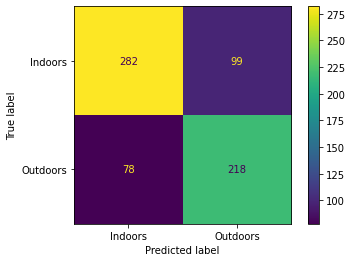

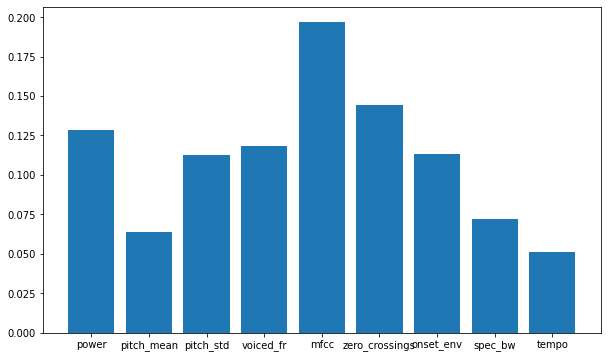

In [ ]:
#Confusion Matrix
cm = metrics.confusion_matrix(yv_p, (y_val))
cmd_obj=ConfusionMatrixDisplay(cm,display_labels=['Indoors','Outdoors'])
cmd_obj.plot();

# classification report
print(classification_report(yv_p,y_val)) 

#plotting graph for contribution of features for this model
plt.figure (figsize=(10,6))
plt.bar(data.columns, classifier.feature_importances_)

**Inference**: 
*   Xg boost method using randomsearchcv perfectly suits for this application.

*   Recall score for indoor and outdoor data is 74%. From the precison an f-score from this model it can be understood that this model might be slightly biased towards indoor data
*   mfcc extracted feature from the audio has a great impact in prediction the environment.





**8.3 Model Traning and Evaluation using RandomForestClassification Model**

Training Accuracy 0.8649334178820546
Validation  Accuracy 0.71
              precision    recall  f1-score   support

           0       0.76      0.72      0.74       380
           1       0.67      0.71      0.69       297

    accuracy                           0.72       677
   macro avg       0.71      0.72      0.71       677
weighted avg       0.72      0.72      0.72       677



<BarContainer object of 9 artists>

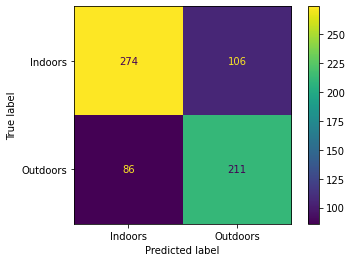

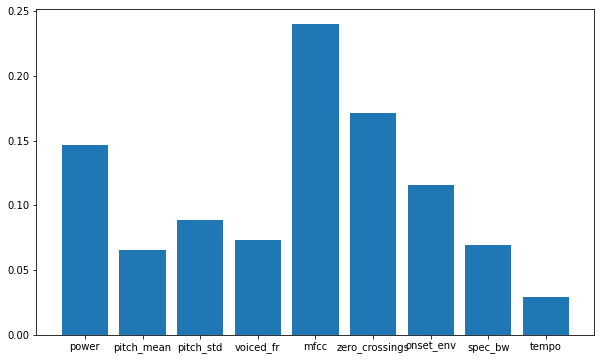

In [17]:
from sklearn.ensemble import RandomForestClassifier
rf_1=RandomForestClassifier(n_estimators=150,max_depth=7,max_features='sqrt',random_state=2)
rf_1.fit(X_train,y_train)
yt_p1 = rf_1.predict(X_train)
yv_p1 = rf_1.predict(X_val)

print('Training Accuracy', np.mean(yt_p1==y_train))
print('Validation  Accuracy',np.round(np.mean(yv_p1==y_val),2))
rf_val_accuracy=accuracy_score(y_val, yv_p1)

#Confusion Matrix
cm = metrics.confusion_matrix(yv_p, (y_val))
cmd_obj=ConfusionMatrixDisplay(cm,display_labels=['Indoors','Outdoors'])
cmd_obj.plot();

# classification report
print(classification_report(yv_p,y_val)) 

#plotting graph for contribution of features for this model
plt.figure (figsize=(10,6))
plt.bar(data.columns, rf_1.feature_importances_)

**Inference:** RandomForest classifier has a training accuracy of 86% and a testing accuracy of 71%.

This model is slightly overfitting the training data.

### **9. Conclusions**

*  Utimetly XG boost by optimizing its hyperparameters through randomizedcv method is considered as the best model it has obtained a training accuracy of 82% and validation accuracy of 77%. 
*   mfcc feature has a great impact in improving the accuracy in my model.

*   Extracting more features has drastically improved the accuracy of the model

*   Althought precision,recall,f-score for randomforest classifier and xgboost are same validation accuracy for xgboost is 77% which is higher than that obtained through randomforest classifier 73%. 








